# Introduction

In this notebook we develop a Distributed Deep Deterministic Policy Gradients (D3PG) model and analyse its performance on Unity's Tennis environment with two agents.

This part of the last project: *Collaboration and Competition* of **Deep Reinforcement Learning for Enterprise** Course in *Udacity*.

## 0 - Importing Packages

Importing all required packages.

In [2]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from training_d3pg_agent_final import d3pg
from d3pg_agent_final import Agent

## 1 - Initialising Environment

Initialising Unity environment to analyse.

In [2]:
env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 2 - Untrained Agents

In [3]:
for i in range(1, 6):                                      # play game for 5 episodes
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
    action_size = brain.vector_action_space_size  
    states = env_info.vector_observations                  # get the current state (for each agent)
    num_agents = len(env_info.agents)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


## 3 - Training with a D3PG model

### 3.1 - Barth-Maron's hyperparameters

We start by using the BM D3PG model as a first attempt to solve the environment, we increase the initial noise parameter and the maximum number of episodes per training session as initially the agent does not receive much signal from this environment.

Defining a dictionary with all hyperparameters inputs in the learning model. Using the values mentioned in the Results section of Barth-Maron's paper.

In [43]:
dic = {'n_episodes': 5000,       # number episodes used for learning
       'max_t': 1000,            # maximum number of steps per episode 
       'actor_fc1_units': 400,   # number of units for first hidden layer actor net
       'actor_fc2_units': 300,   # number of units for second hidden layer actor net
       'critic_fc1_units': 400,  # number of units for first hidden layer critic net
       'critic_fc2_units': 300,  # number of units for second hidden layer critic net
       'buffer_size': int(1e6),  # replay buffer size
       'batch_size': 256,        # minibatch size
       'gamma': 0.99,            # discount factor
       'tau': 1e-3,              # for soft update of target parameters
       'lr_actor': 1e-4,         # learning rate of the actor 
       'lr_critic': 1e-4,        # learning rate of the critic
       'weight_decay': 0,        # L2 weight decay
       'update_every': 1,        # learning step frequency per acting step
       'epsilon': 0.9,           # uniform noise process initial scale parameter
       'file': 'chpt_bm'}        # file name to save agent's net weights

Defining two useful functions to transform the scores an times results dictionaries into dataframes.
Initialising dictionaries to collect results.

In [3]:
def maxlen(dic):
    l = 0
    for e in dic.values():
        if len(e) > l:
            l = len(e)
    return l

def dic_fix(dic):
    dicF = {}
    ml = maxlen(dic)
    for i , e in enumerate(dic.values()):
        new = [None] * (ml - len(e))
        dicF[i] = e + new
    return dicF


In [45]:
scores_dic = {}
times_dic = {}

for i in range(10):
    print('\nTraining session:\t' + str(i+1))
    scores, times = d3pg(env, dic)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_bm_analysis.csv')
times_df.to_csv('times_bm_analysis.csv')


Training session:	1
Episode 100	Average Score: 0.00	Time Split: 35.40			 
Episode 200	Average Score: 0.00	Time Split: 37.57			 
Episode 300	Average Score: 0.01	Time Split: 43.59			 
Episode 400	Average Score: 0.01	Time Split: 42.78			 
Episode 500	Average Score: 0.00	Time Split: 37.79			 
Episode 600	Average Score: 0.00	Time Split: 37.77			 
Episode 700	Average Score: 0.00	Time Split: 40.18			 
Episode 800	Average Score: 0.01	Time Split: 46.79			 
Episode 900	Average Score: 0.02	Time Split: 48.50			 
Episode 1000	Average Score: 0.03	Time Split: 52.93			 
Episode 1100	Average Score: 0.06	Time Split: 71.42			 
Episode 1200	Average Score: 0.07	Time Split: 85.52			 
Episode 1300	Average Score: 0.09	Time Split: 89.12			 
Episode 1400	Average Score: 0.08	Time Split: 87.68			 
Episode 1500	Average Score: 0.11	Time Split: 105.80			 
Episode 1600	Average Score: 0.15	Time Split: 160.03			 
Episode 1700	Average Score: 0.22	Time Split: 238.79			 
Episode 1771	Average Score: 0.50	Time Elapsed: 173

Episode 100	Average Score: 0.01	Time Split: 38.97			 
Episode 200	Average Score: 0.00	Time Split: 38.38			 
Episode 300	Average Score: 0.01	Time Split: 41.67			 
Episode 400	Average Score: 0.01	Time Split: 45.87			 
Episode 500	Average Score: 0.04	Time Split: 61.70			 
Episode 600	Average Score: 0.04	Time Split: 60.96			 
Episode 700	Average Score: 0.04	Time Split: 63.53			 
Episode 800	Average Score: 0.04	Time Split: 61.00			 
Episode 900	Average Score: 0.09	Time Split: 84.96			 
Episode 1000	Average Score: 0.15	Time Split: 153.87			 
Episode 1100	Average Score: 0.39	Time Split: 402.87			 
Episode 1133	Average Score: 0.50	Time Elapsed: 1248.84
Environment solved in 1033 episodes!	Average Score: 0.50	Time Elapsed: 1248.84

Training session:	7
Episode 100	Average Score: 0.00	Time Split: 36.32			 
Episode 200	Average Score: 0.00	Time Split: 37.01			 
Episode 300	Average Score: 0.00	Time Split: 37.05			 
Episode 400	Average Score: 0.00	Time Split: 36.91			 
Episode 500	Average Score: 0.00

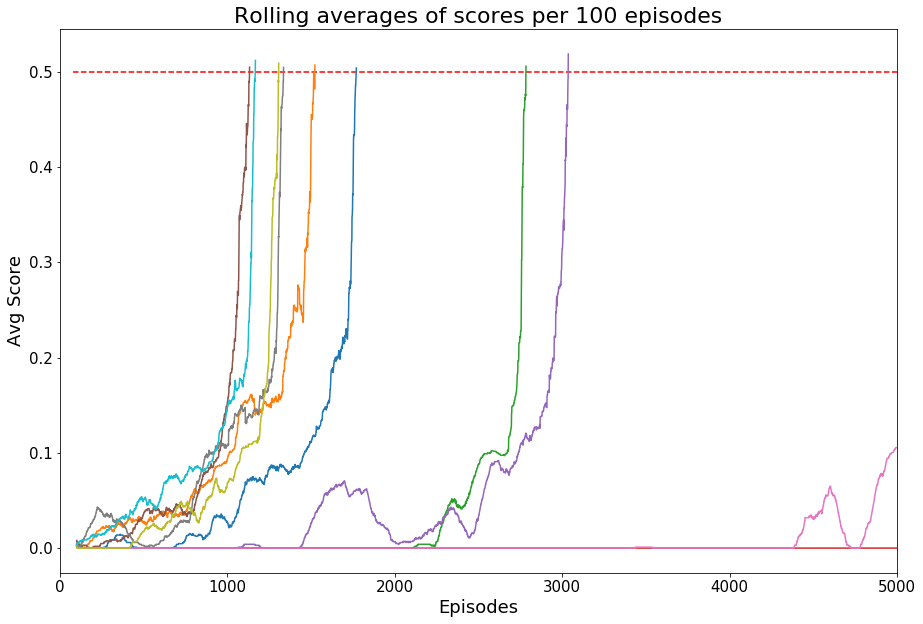

In [3]:
scores_df = pd.read_csv('scores_bm_analysis.csv', index_col=0)
times_df = pd.read_csv('times_bm_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(0,5000), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=5020, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("AvgBM.png")

In [47]:
completed_sessions = scores_df.iloc[:, pd.Series(np.isnan(scores_df.iloc[4999])).values].count() - 100
completed_sessions.describe()

count       8.000000
mean     1657.375000
std       742.978357
min      1033.000000
25%      1172.250000
50%      1329.500000
75%      1924.250000
max      2937.000000
dtype: float64

The Original D3PG model **solves the environment 80% of the times** when maximum number of episodes per training session is 5000. In successful training sessions, it takes on average **1650 episodes**. The distribution shows a dispersion of **750 episodes** standard deviation.

### 3.2 - D3PG with previously tuned hyperparameters

We now use the tuned D3PG model from last project. We also increase the initial noise parameter.

In [3]:
dic = {'n_episodes': 5000,       # number episodes used for learning
       'max_t': 1000,            # maximum number of steps per episode 
       'actor_fc1_units': 400,   # number of units for first hidden layer actor net
       'actor_fc2_units': 300,   # number of units for second hidden layer actor net
       'critic_fc1_units': 400,  # number of units for first hidden layer critic net
       'critic_fc2_units': 300,  # number of units for second hidden layer critic net
       'buffer_size': int(1e5),  # replay buffer size
       'batch_size': 128,        # minibatch size
       'gamma': 0.99,            # discount factor
       'tau': 1e-3,              # for soft update of target parameters
       'lr_actor': 1e-4,         # learning rate of the actor 
       'lr_critic': 1e-4,        # learning rate of the critic
       'weight_decay': 0,     # L2 weight decay
       'update_every': 1,        # learning step frequency per acting step
       'epsilon': 0.9,           # uniform noise process initial scale parameter
       'file': 'chpt_d3pg'}      # file name to save agent's net weights

In [4]:
scores_dic = {}
times_dic = {}

for i in range(50):
    print('Training session:\t' + str(i+1))
    scores, times = d3pg(env, dic, SuccessStop=True)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_D3PG_analysis.csv')
times_df.to_csv('times_D3PG_analysis.csv')

Training session:	1
Episode 100	Average Score: 0.00	Time Split: 23.10			 
Episode 200	Average Score: 0.00	Time Split: 22.29			 
Episode 300	Average Score: 0.00	Time Split: 22.21			 
Episode 400	Average Score: 0.00	Time Split: 22.32			 
Episode 500	Average Score: 0.00	Time Split: 22.34			 
Episode 600	Average Score: 0.00	Time Split: 22.41			 
Episode 700	Average Score: 0.00	Time Split: 22.63			 
Episode 800	Average Score: 0.00	Time Split: 22.51			 
Episode 900	Average Score: 0.00	Time Split: 22.90			 
Episode 1000	Average Score: 0.00	Time Split: 23.10			 
Episode 1100	Average Score: 0.00	Time Split: 23.50			 
Episode 1200	Average Score: 0.00	Time Split: 24.12			 
Episode 1300	Average Score: 0.00	Time Split: 24.61			 
Episode 1400	Average Score: 0.00	Time Split: 25.34			 
Episode 1500	Average Score: 0.00	Time Split: 25.98			 
Episode 1600	Average Score: 0.00	Time Split: 26.49			 
Episode 1700	Average Score: 0.00	Time Split: 26.87			 
Episode 1800	Average Score: 0.00	Time Split: 27.83			 

Episode 100	Average Score: 0.00	Time Split: 21.80			 
Episode 200	Average Score: 0.00	Time Split: 23.56			 
Episode 300	Average Score: 0.00	Time Split: 23.30			 
Episode 400	Average Score: 0.00	Time Split: 23.54			 
Episode 500	Average Score: 0.00	Time Split: 23.74			 
Episode 600	Average Score: 0.00	Time Split: 23.53			 
Episode 700	Average Score: 0.00	Time Split: 23.02			 
Episode 800	Average Score: 0.00	Time Split: 23.26			 
Episode 900	Average Score: 0.00	Time Split: 23.36			 
Episode 1000	Average Score: 0.00	Time Split: 23.61			 
Episode 1100	Average Score: 0.00	Time Split: 23.96			 
Episode 1200	Average Score: 0.00	Time Split: 24.42			 
Episode 1300	Average Score: 0.00	Time Split: 24.70			 
Episode 1400	Average Score: 0.00	Time Split: 24.56			 
Episode 1500	Average Score: 0.00	Time Split: 25.25			 
Episode 1600	Average Score: 0.00	Time Split: 26.32			 
Episode 1700	Average Score: 0.00	Time Split: 26.05			 
Episode 1800	Average Score: 0.00	Time Split: 26.21			 
Episode 1900	Averag

Episode 1200	Average Score: 0.08	Time Split: 52.30			 
Episode 1300	Average Score: 0.09	Time Split: 54.91			 
Episode 1400	Average Score: 0.13	Time Split: 76.35			 
Episode 1500	Average Score: 0.12	Time Split: 74.50			 
Episode 1600	Average Score: 0.12	Time Split: 78.95			 
Episode 1700	Average Score: 0.20	Time Split: 130.15			 
Episode 1800	Average Score: 0.29	Time Split: 194.45			 
Episode 1879	Average Score: 0.51	Time Elapsed: 20149.82
Environment solved in 1779 episodes!	Average Score: 0.51	Time Elapsed: 20149.82
Training session:	24
Episode 100	Average Score: 0.00	Time Split: 24.35			 
Episode 200	Average Score: 0.00	Time Split: 23.85			 
Episode 300	Average Score: 0.00	Time Split: 22.87			 
Episode 400	Average Score: 0.00	Time Split: 23.42			 
Episode 500	Average Score: 0.00	Time Split: 22.72			 
Episode 600	Average Score: 0.00	Time Split: 23.64			 
Episode 700	Average Score: 0.00	Time Split: 23.10			 
Episode 800	Average Score: 0.00	Time Split: 22.80			 
Episode 900	Average Scor

Episode 1500	Average Score: 0.30	Time Split: 207.50			 
Episode 1557	Average Score: 0.50	Time Elapsed: 1167.64
Environment solved in 1457 episodes!	Average Score: 0.50	Time Elapsed: 1167.64
Training session:	33
Episode 100	Average Score: 0.00	Time Split: 22.84			 
Episode 200	Average Score: 0.00	Time Split: 24.55			 
Episode 300	Average Score: 0.01	Time Split: 26.34			 
Episode 400	Average Score: 0.01	Time Split: 25.45			 
Episode 500	Average Score: 0.01	Time Split: 24.88			 
Episode 600	Average Score: 0.00	Time Split: 23.51			 
Episode 700	Average Score: 0.00	Time Split: 23.08			 
Episode 800	Average Score: 0.00	Time Split: 23.33			 
Episode 900	Average Score: 0.00	Time Split: 23.36			 
Episode 1000	Average Score: 0.00	Time Split: 23.51			 
Episode 1100	Average Score: 0.03	Time Split: 34.32			 
Episode 1200	Average Score: 0.07	Time Split: 46.16			 
Episode 1300	Average Score: 0.11	Time Split: 67.51			 
Episode 1400	Average Score: 0.17	Time Split: 125.99			 
Episode 1500	Average Score:

Episode 100	Average Score: 0.00	Time Split: 22.26			 
Episode 200	Average Score: 0.00	Time Split: 24.18			 
Episode 300	Average Score: 0.00	Time Split: 24.52			 
Episode 400	Average Score: 0.01	Time Split: 28.47			 
Episode 500	Average Score: 0.01	Time Split: 27.31			 
Episode 600	Average Score: 0.01	Time Split: 27.77			 
Episode 700	Average Score: 0.00	Time Split: 23.04			 
Episode 800	Average Score: 0.00	Time Split: 23.87			 
Episode 900	Average Score: 0.01	Time Split: 24.62			 
Episode 1000	Average Score: 0.00	Time Split: 23.95			 
Episode 1100	Average Score: 0.00	Time Split: 27.19			 
Episode 1200	Average Score: 0.02	Time Split: 35.67			 
Episode 1300	Average Score: 0.07	Time Split: 51.92			 
Episode 1400	Average Score: 0.05	Time Split: 39.93			 
Episode 1500	Average Score: 0.09	Time Split: 56.28			 
Episode 1600	Average Score: 0.33	Time Split: 221.02			 
Episode 1700	Average Score: 0.31	Time Split: 222.41			 
Episode 1720	Average Score: 0.50	Time Elapsed: 1092.04
Environment solve

ValueError: arrays must all be same length

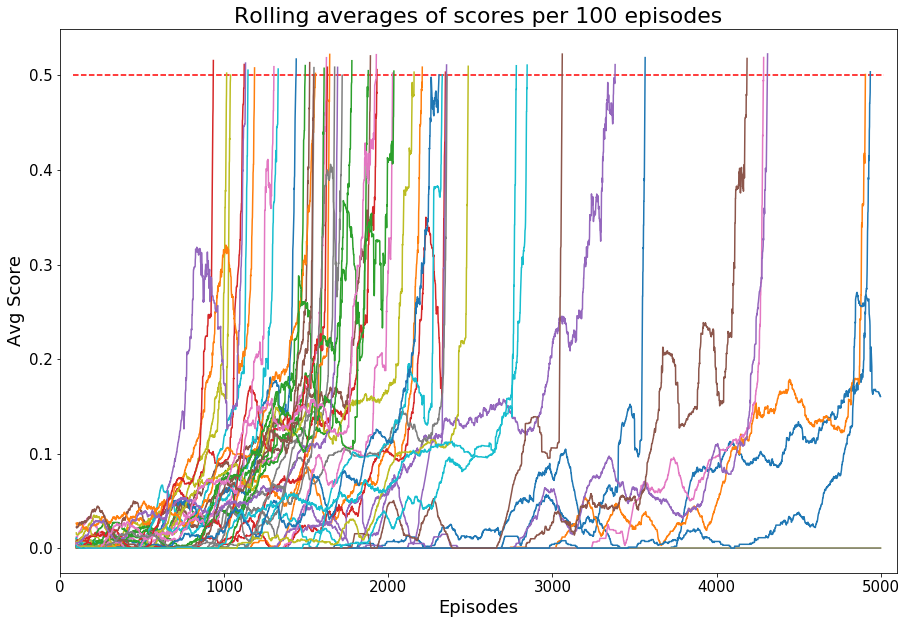

In [11]:
scores_df = pd.read_csv('scores_D3PG_analysis.csv',index_col=0)
times_df = pd.read_csv('times_D3PG_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(0,5100), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=5020, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgD3PGbase.png")

In [41]:
completed_sessions = scores_df.iloc[:, pd.Series(np.isnan(scores_df.iloc[4999])).values].count() - 100
completed_sessions.describe()

count      47.000000
mean     2053.510638
std      1024.191810
min       835.000000
25%      1434.000000
50%      1779.000000
75%      2258.000000
max      4838.000000
dtype: float64

Tuned D3PG model **solves the environment 94% of the times** when maximum number of episodes per training session is 5000. This is a better performance than BM D3PG model. In successful training sessions, it takes on average **2000 episodes**. This is a worse performance than the BM D3PG model. The distribution shows a dispersion of **1000 episodes** standard deviation.

### 3.3 - Tuning D3PG model

We will take a blend of both models as our base case. We will try to tune the model further for this specific environment. 

This environment biggest hurdle seems to be the initial lack of signal. Once the agent establishes the source of reward it learns quite quickly in a stable fashion and solves the environment.

We will look further into initial error size parameter, batch_size, buffer_size and weight_decay.

In [50]:
dic = {'n_episodes': 5000,       # number episodes used for learning
       'max_t': 1000,            # maximum number of steps per episode 
       'actor_fc1_units': 400,   # number of units for first hidden layer actor net
       'actor_fc2_units': 300,   # number of units for second hidden layer actor net
       'critic_fc1_units': 400,  # number of units for first hidden layer critic net
       'critic_fc2_units': 300,  # number of units for second hidden layer critic net
       'buffer_size': int(1e5),  # replay buffer size
       'batch_size': 256,        # minibatch size
       'gamma': 0.99,            # discount factor
       'tau': 1e-3,              # for soft update of target parameters
       'lr_actor': 1e-4,         # learning rate of the actor 
       'lr_critic': 1e-4,        # learning rate of the critic
       'weight_decay': 0,        # L2 weight decay
       'update_every': 1,        # learning step frequency per acting step
       'epsilon': 0.9,           # uniform noise process initial scale parameter
       'file': 'chpt_d3pg_tun'}  # file name to save agent's net weights

In [51]:
shocks_rota = {'base 1': ('max_t', 'abs', 1000),
              'base 2': ('max_t', 'abs', 1000),
              'base 3': ('max_t', 'abs', 1000),
              'base 4': ('max_t', 'abs', 1000),
              'base 5': ('max_t', 'abs', 1000),
              'epsilon + 1': ('epsilon', 'abs', 1.5),
              'epsilon + 2': ('epsilon', 'abs', 1.5),
              'epsilon - 1': ('epsilon', 'abs', 0.7),
              'epsilon - 2': ('epsilon', 'abs', 0.7),
              'epsilon - 3': ('epsilon', 'abs', 0.7),
              'epsilon -- 1': ('epsilon', 'abs', 0.5),
              'epsilon -- 2': ('epsilon', 'abs', 0.5),
              'epsilon -- 3': ('epsilon', 'abs', 0.5),
              'L2 + 1': ('weight_decay', 'abs', 0.000001),
              'L2 + 2': ('weight_decay', 'abs', 0.000001),
              'L2 ++ 1': ('weight_decay', 'abs', 0.0001),
              'L2 ++ 2': ('weight_decay', 'abs', 0.0001),
              'batch_size + 1': ('batch_size', 'abs', 512),
              'batch_size + 2': ('batch_size', 'abs', 512),
              'buffer_size - 1': ('buffer_size', 'abs', int(1e-4)),
              'buffer_size - 2': ('buffer_size', 'abs', int(1e-4)),
             }

In [52]:
scores_dic = {}
times_dic = {}

for k, v in shocks_rota.items():
    print('Applying shock:\t' + k)
    dic_shocked = dic.copy()
    if v[1] == 'rel':
        dic_shocked[v[0]] = dic[v[0]] * v[2]
    else:
        dic_shocked[v[0]] = v[2]
        
    scores, times = d3pg(env, dic_shocked, SuccessStop=True)
    
    scores_dic[k] = scores
    times_dic[k] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_D3PG_hyp_analysis.csv')
times_df.to_csv('times_D3PG_hyp_analysis.csv')

Applying shock:	base 1
Episode 100	Average Score: 0.00	Time Split: 37.89			 
Episode 200	Average Score: 0.00	Time Split: 40.49			 
Episode 300	Average Score: 0.00	Time Split: 39.78			 
Episode 400	Average Score: 0.01	Time Split: 41.73			 
Episode 500	Average Score: 0.00	Time Split: 39.53			 
Episode 600	Average Score: 0.03	Time Split: 52.65			 
Episode 700	Average Score: 0.04	Time Split: 62.64			 
Episode 800	Average Score: 0.07	Time Split: 70.96			 
Episode 900	Average Score: 0.06	Time Split: 69.55			 
Episode 1000	Average Score: 0.08	Time Split: 80.55			 
Episode 1100	Average Score: 0.15	Time Split: 139.18			 
Episode 1200	Average Score: 0.14	Time Split: 141.95			 
Episode 1300	Average Score: 0.17	Time Split: 179.26			 
Episode 1385	Average Score: 0.51	Time Elapsed: 1507.67
Environment solved in 1285 episodes!	Average Score: 0.51	Time Elapsed: 1507.67
Applying shock:	base 2
Episode 100	Average Score: 0.00	Time Split: 35.11			 
Episode 200	Average Score: 0.00	Time Split: 37.51			 
Epi

Episode 4700	Average Score: 0.00	Time Split: 57.56			 
Episode 4800	Average Score: 0.00	Time Split: 57.63			 
Episode 4900	Average Score: 0.00	Time Split: 56.87			 
Episode 5000	Average Score: 0.00	Time Split: 60.73			 
Applying shock:	epsilon - 3
Episode 100	Average Score: 0.00	Time Split: 38.57			 
Episode 200	Average Score: 0.00	Time Split: 37.58			 
Episode 300	Average Score: 0.00	Time Split: 39.79			 
Episode 400	Average Score: 0.00	Time Split: 38.67			 
Episode 500	Average Score: 0.00	Time Split: 42.13			 
Episode 600	Average Score: 0.00	Time Split: 38.85			 
Episode 700	Average Score: 0.03	Time Split: 53.38			 
Episode 800	Average Score: 0.00	Time Split: 39.26			 
Episode 900	Average Score: 0.02	Time Split: 52.82			 
Episode 1000	Average Score: 0.03	Time Split: 56.99			 
Episode 1100	Average Score: 0.07	Time Split: 75.92			 
Episode 1200	Average Score: 0.05	Time Split: 71.14			 
Episode 1300	Average Score: 0.09	Time Split: 83.78			 
Episode 1400	Average Score: 0.10	Time Split: 1

Episode 800	Average Score: 0.01	Time Split: 3.78			 
Episode 900	Average Score: 0.02	Time Split: 4.17			 
Episode 1000	Average Score: 0.02	Time Split: 4.13			 
Episode 1100	Average Score: 0.01	Time Split: 3.95			 
Episode 1200	Average Score: 0.02	Time Split: 4.16			 
Episode 1300	Average Score: 0.02	Time Split: 4.20			 
Episode 1400	Average Score: 0.02	Time Split: 3.91			 
Episode 1500	Average Score: 0.01	Time Split: 4.25			 
Episode 1600	Average Score: 0.02	Time Split: 4.36			 
Episode 1700	Average Score: 0.01	Time Split: 4.10			 
Episode 1800	Average Score: 0.02	Time Split: 4.47			 
Episode 1900	Average Score: 0.02	Time Split: 4.38			 
Episode 2000	Average Score: 0.02	Time Split: 4.58			 
Episode 2100	Average Score: 0.02	Time Split: 4.81			 
Episode 2200	Average Score: 0.02	Time Split: 4.19			 
Episode 2300	Average Score: 0.01	Time Split: 4.37			 
Episode 2400	Average Score: 0.02	Time Split: 4.27			 
Episode 2500	Average Score: 0.01	Time Split: 4.13			 
Episode 2600	Average Score: 0.

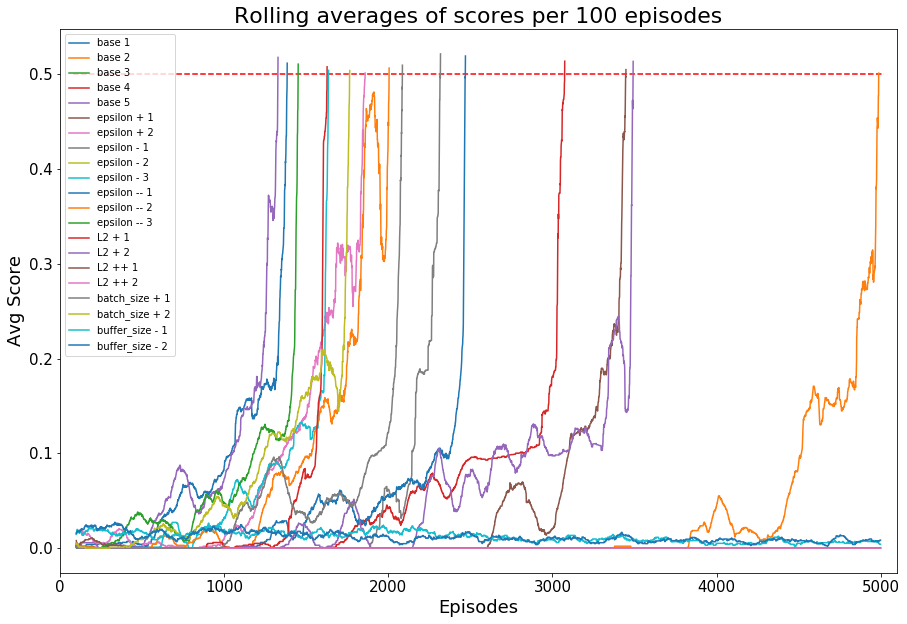

In [65]:
scores_df = pd.read_csv('scores_D3PG_hyp_analysis.csv',index_col=0)
times_df = pd.read_csv('times_D3PG_hyp_analysis.csv', index_col=0)
columns_names = {str(i): k for i,k in enumerate(shocks_rota.keys())}
scores_df.rename(columns=columns_names, inplace=True)
times_df.rename(columns=columns_names, inplace=True)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=True, xlim=(0,5100), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=5020, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgD3PGhyp.png")

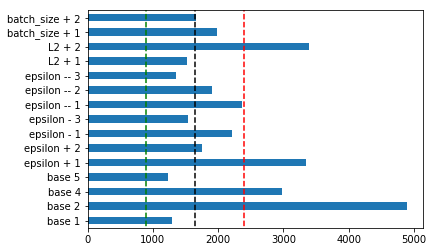

In [67]:
completed_sessions = scores_df.iloc[:, pd.Series(np.isnan(scores_df.iloc[4999])).values].count() - 100
ax = completed_sessions.plot.barh()
ax.vlines(900, ymin = -2, ymax=25, linestyles='dashed', label='baseline', colors='g')
ax.vlines(1650, ymin = -2, ymax=25, linestyles='dashed', label='baseline', colors='k')
ax.vlines(2400, ymin = -2, ymax=25, linestyles='dashed', label='baseline', colors='r')

A few takeaways from the analysis:
* decreasing the buffer size does not seem to work;
* surprisingly low dependency on lower epsilon and larger batch size;
* low non-zero L2 does not affect performance and can potentially stop the tremor of the raquet.



### 3.4 - Long learning session with tuned D3PG model

In [4]:
dic = {'n_episodes': 1500,          # number episodes used for learning
       'max_t': 1000,               # maximum number of steps per episode 
       'actor_fc1_units': 400,      # number of units for first hidden layer actor net
       'actor_fc2_units': 300,      # number of units for second hidden layer actor net
       'critic_fc1_units': 400,     # number of units for first hidden layer critic net
       'critic_fc2_units': 300,     # number of units for second hidden layer critic net
       'buffer_size': int(1e6),     # replay buffer size
       'batch_size': 512,           # minibatch size
       'gamma': 0.99,               # discount factor
       'tau': 1e-3,                 # for soft update of target parameters
       'lr_actor': 1e-4,            # learning rate of the actor 
       'lr_critic': 1e-4,           # learning rate of the critic
       'weight_decay': 0.000001,    # L2 weight decay
       'update_every': 1,           # learning step frequency per acting step
       'epsilon': 0.5,              # uniform noise process initial scale parameter
       'file': 'chpt_final_d3pg'}   # file name to save agent's net weights

In [5]:
scores_dic = {}
times_dic = {}

for i in range(1):
    print('Training session:\t' + str(i+1))
    scores, times = d3pg(env, dic, SuccessStop=False)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_final_D3PG.csv')
times_df.to_csv('times_final_D3PG.csv')

Training session:	1
Episode 100	Average Score: 0.02	Time Split: 68.00			 
Episode 200	Average Score: 0.01	Time Split: 72.06			 
Episode 300	Average Score: 0.00	Time Split: 65.10			 
Episode 400	Average Score: 0.00	Time Split: 61.71			 
Episode 500	Average Score: 0.00	Time Split: 61.24			 
Episode 600	Average Score: 0.00	Time Split: 61.93			 
Episode 700	Average Score: 0.03	Time Split: 87.15			 
Episode 800	Average Score: 0.03	Time Split: 89.21			 
Episode 900	Average Score: 0.06	Time Split: 130.32			 
Episode 1000	Average Score: 0.09	Time Split: 163.55			 
Episode 1100	Average Score: 0.14	Time Split: 233.88			 
Episode 1200	Average Score: 0.13	Time Split: 208.16			 
Episode 1300	Average Score: 0.32	Time Split: 589.94			 
Episode 1400	Average Score: 1.92	Time Split: 3791.79			 
Episode 1500	Average Score: 2.36	Time Split: 5300.35			 


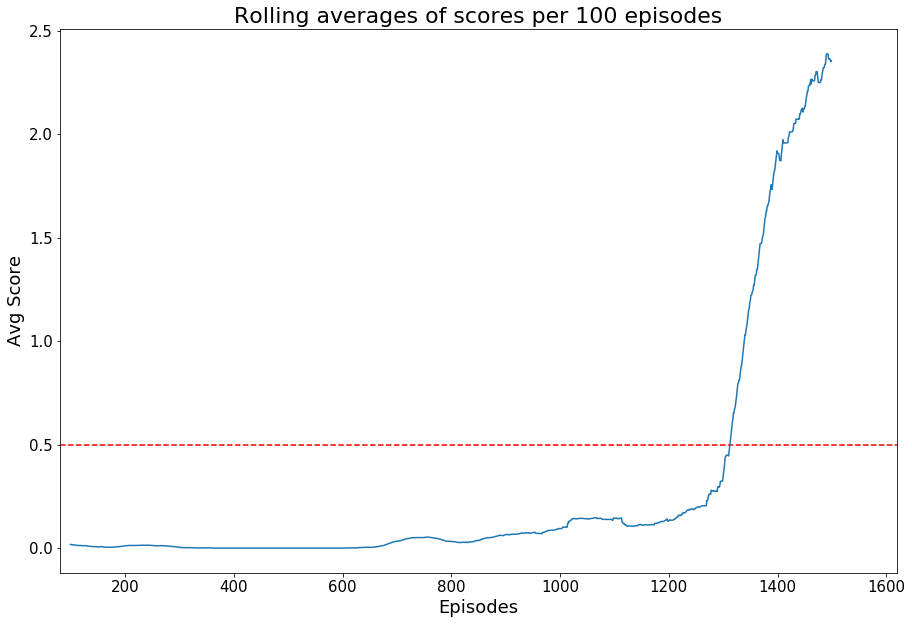

In [7]:
scores_df = pd.read_csv('scores_final_D3PG.csv',index_col=0)
times_df = pd.read_csv('times_final_D3PG.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(80,1620), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(0.5, xmin = 80, xmax=1620, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgD3PGfinal.png")

## 4 - Watch Trained Agents

In [10]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
action_size = brain.vector_action_space_size  
states = env_info.vector_observations
state = states[0]
state_size = len(state)
num_agents = len(env_info.agents)
scores = np.zeros(num_agents) 
agent = Agent(num_agents=num_agents, state_size=state_size, action_size=action_size)
agent.actor_local.load_state_dict(torch.load('chpt_final_d3pg_actor.pth'))

while True:
    actions = agent.act(states, add_noise=False)        # select an action  
    env_info = env.step(actions)[brain_name]            # send all actions to tne environment
    states = env_info.vector_observations               # get next state   
    dones = env_info.local_done                         # see if episode finished
    scores += env_info.rewards                          # update the score     
    if np.any(dones):                                   # exit loop if episode finished
        break
print('Total score for this episode: {}'.format(np.mean(scores)))

Total score for this episode: 2.650000039488077


We need to work on the tremour of the raquet by regularising the neural network. Learn for a few episodes with L2 high. 

In [11]:
from tuning_d3pg_agent_final import d3pg_tuning

In [16]:
dic = {'n_episodes': 500,          # number episodes used for learning
       'max_t': 1000,               # maximum number of steps per episode 
       'actor_fc1_units': 400,      # number of units for first hidden layer actor net
       'actor_fc2_units': 300,      # number of units for second hidden layer actor net
       'critic_fc1_units': 400,     # number of units for first hidden layer critic net
       'critic_fc2_units': 300,     # number of units for second hidden layer critic net
       'buffer_size': int(1e6),     # replay buffer size
       'batch_size': 512,           # minibatch size
       'gamma': 0.99,               # discount factor
       'tau': 1e-3,                 # for soft update of target parameters
       'lr_actor': 1e-4,            # learning rate of the actor 
       'lr_critic': 1e-4,           # learning rate of the critic
       'weight_decay': 0.00001,      # L2 weight decay
       'update_every': 1,           # learning step frequency per acting step
       'epsilon': 0.1,              # uniform noise process initial scale parameter
       'file': 'chpt_tremour_fixing_d3pg'}   # file name to save agent's net weights

In [ ]:
scores_dic = {}
times_dic = {}

for i in range(1):
    print('Training session:\t' + str(i+1))
    scores, times = d3pg_tuning(env, dic, SuccessStop=True, agent_name="final_d3pg")
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_tremour_fixing_D3PG.csv')
times_df.to_csv('times_tremour_fixing_D3PG.csv')

Training session:	1
Episode 97	Average Score: 0.39	Time Elapsed: 730.85

In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
action_size = brain.vector_action_space_size  
states = env_info.vector_observations
state = states[0]
state_size = len(state)
num_agents = len(env_info.agents)
scores = np.zeros(num_agents) 
agent = Agent(num_agents=num_agents, state_size=state_size, action_size=action_size)
agent.actor_local.load_state_dict(torch.load('chpt_tremour_fixing_d3pg_actor.pth'))

while True:
    actions = agent.act(states, add_noise=False)        # select an action  
    env_info = env.step(actions)[brain_name]            # send all actions to tne environment
    states = env_info.vector_observations               # get next state   
    dones = env_info.local_done                         # see if episode finished
    scores += env_info.rewards                          # update the score     
    if np.any(dones):                                   # exit loop if episode finished
        break
print('Total score for this episode: {}'.format(np.mean(scores)))

Total score for this episode: 2.600000038743019
